# Zadanie 1: optymalizacja gradientowa

Termin realizacji: 17 marca 2025

Wybierz jedną z testowych funkcji o dwóch zmiennych do optymalizacji (z [https://en.wikipedia.org/wiki/Test_functions_for_optimization](Test_functions_for_optimization)) (oprócz "sphere function", "Matyas function" i "Booth function").

Zadanie do oddania przez MS Teams. Do oddania: kod oraz krótkie sprawozdanie w PDF (można na przykład przy użyciu `quarto render notebook.ipynb --to pdf`).

## Na 3.0

Do realizacji:

1. Weź implementację optymalizacji gradientowej z zadania z ostatnich ćwiczeń.
2. Wylosuj 10 punktów z dziedziny przeszukiwania z tabelki. Dla każdego z nich przeprowadź 100 kroków optymalizacji metodą największego spadku ze stałym krokiem. Narysuj wykres zależności wartości funkcji optymalizowanej od kroku optymalizacji.
3. Przeprowadź procedurę dla kilku kroków. Spróbuj zilustrować brak zbieżności, szybką zbieżność i powolną zbieżność.

## Na 4.0

Do realizacji:

1. Punkty z zadania na 3.0.
2. Zamień stały krok z poprzedniego zadania na warunek wystarczającego spadku Armijo. Jako początkowy bracket przyjmij $[0, 1]$. Porównaj zbieżność metody o stałym kroku z przeszukiwaniem liniowym za pomocą wykresów wartości w konkretnym kroku uśrednione między poszczególnymi punktami początkowymi. Porównaj wyniki dla 6 różnych kombinacji parametrów metody Armijo.

## Na 5.0

Do realizacji:

1. Punkty z zadania na 4.0.
2. Zamień stały bracket $[0, 1]$ z poprzedniego punktu na metodę automatycznie określającą bracket (przykład z wykładu). Porównaj wyniki z poprzednią metodą dla minimum 6 zestawów parametrów bracketingu.


In [1]:
using Random
using Distributions
using Plots
using LinearAlgebra

# Optymalizacja z fixed step

In [2]:
function gradient_descent_fixed_step(x, y, α, iterations, fun, gradient)
    cost_history = []

    for i in 1:iterations
        gradient_x, gradient_y = gradient(x, y)
        x -= α * gradient_x
        y -= α * gradient_y
        push!(cost_history, fun(x, y))
    end

    return x, y, cost_history
end

gradient_descent_fixed_step (generic function with 1 method)

# Funkcja Armijo

In [3]:
function armijo_step_size(x, y, fun, gradient, β=0.5, c=0.1)
   α = 1  
   α_min = 0
   f_old = fun(x, y)
   grad_x, grad_y = gradient(x, y)
   
   while fun(x - α * grad_x, y - α * grad_y) > f_old - c * α * (grad_x^2 + grad_y^2) && α > α_min
        α *= β  
   end
   
   return α
end

armijo_step_size (generic function with 3 methods)

## Optymalizacja z metodą armijo

In [4]:
function gradient_descent_armijo(x, y, iterations, fun, gradient, β=0.5, c=0.1)
   cost_history = []

   for i in 1:iterations
       grad_x, grad_y = gradient(x, y)

       α = armijo_step_size(x, y, fun, gradient, β, c)

       x -= α * grad_x
       y -= α * grad_y
       push!(cost_history, fun(x, y))
   end

   return x, y, cost_history
end

gradient_descent_armijo (generic function with 3 methods)

# Funckja Himmelblaua

In [5]:
function himmelblau(x, y)
   return (x^2 + y - 11)^2 + (x + y^2 - 7)^2
end

himmelblau (generic function with 1 method)

In [6]:
function himmelblau_gradient(x, y)
   df_dx = 4 * x * (x^2 + y - 11) + 2 * (x + y^2 - 7)
   df_dy = 2 * (x^2 + y - 11) + 4 * y * (x + y^2 - 7)
   return df_dx, df_dy
end

himmelblau_gradient (generic function with 1 method)

# Fixed step

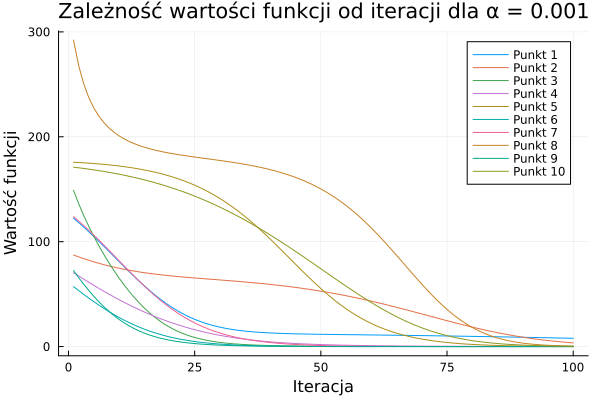

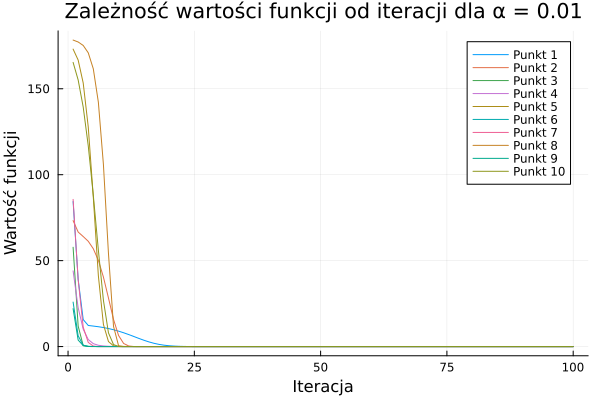

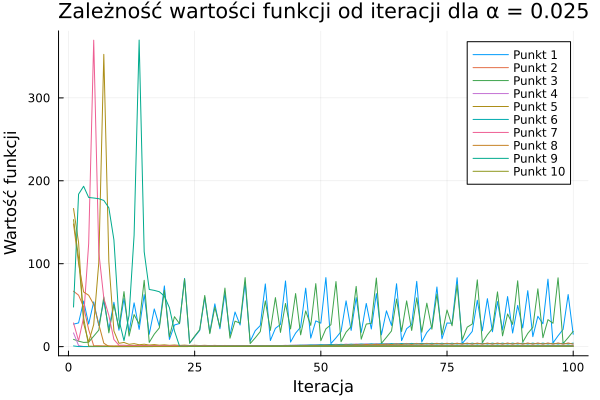

In [7]:
Random.seed!(42)
num_points = 10
start_points = [(rand(Uniform(-5, 5)), rand(Uniform(-5, 5))) for _ in 1:num_points]

all_cost_histories = []
α_values = [0.001, 0.01, 0.025]
iterations = 100

for α in α_values
    for (x0, y0) in start_points
        x_opt, y_opt, cost_history = gradient_descent_fixed_step(x0, y0, α, iterations, himmelblau, himmelblau_gradient)
        push!(all_cost_histories, cost_history)        
    end

    local plt = plot(1:iterations, all_cost_histories[1], label="Punkt 1", xlabel="Iteracja", ylabel="Wartość funkcji", title="Zależność wartości funkcji od iteracji dla α = $α")
    for i in 2:num_points
        plot!(plt, 1:iterations, all_cost_histories[i], label="Punkt $i")
    end
   
    display(plt)
    global all_cost_histories = []
end

## Armijo

In [8]:
iterations = 100
armijo_params = [
    (0.9, 0.05),  
    (0.9, 0.1),  
    (0.7, 0.05),  
    (0.7, 0.1),
    (0.5, 0.05),  
    (0.5, 0.1)
]

6-element Vector{Tuple{Float64, Float64}}:
 (0.9, 0.05)
 (0.9, 0.1)
 (0.7, 0.05)
 (0.7, 0.1)
 (0.5, 0.05)
 (0.5, 0.1)

In [9]:
armijo_results = Dict()

for (β, c) in armijo_params
    avg_costs = zeros(iterations)

    for (x0, y0) in start_points
        _, _, cost_history = gradient_descent_armijo(x0, y0, iterations, himmelblau, himmelblau_gradient, β, c)
        avg_costs += cost_history
    end

    avg_costs /= num_points
    armijo_results[(β, c)] = avg_costs
end

plt = plot()

for ((β, c), costs) in armijo_results
    if !isempty(costs)
        plot!(plt, 1:iterations, costs, label="Armijo (β=$β, c=$c)", lw=2)
    else
        println("Brak danych dla Armijo (β=$β, c=$c)")
    end
end

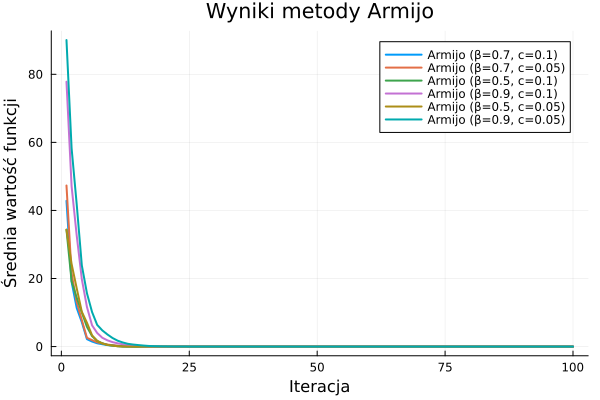

In [10]:
xlabel!("Iteracja")
ylabel!("Średnia wartość funkcji")
title!("Wyniki metody Armijo")
display(plt)

## Porównanie armijo i fixed step

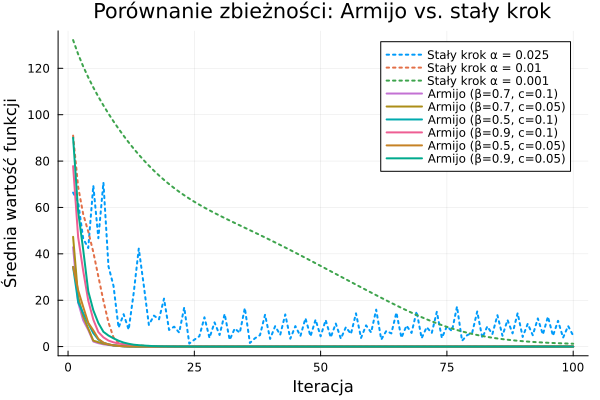

In [11]:
plt = plot()
fixed_step_results = Dict()

for α in α_values
    avg_costs = zeros(iterations)
    
    for (x0, y0) in start_points
        _, _, cost_history = gradient_descent_fixed_step(x0, y0, α, iterations, himmelblau, himmelblau_gradient)
        avg_costs += cost_history
    end
    
    avg_costs /= num_points
    fixed_step_results[α] = avg_costs
end

for (α, costs) in fixed_step_results
    plot!(plt, 1:iterations, costs, label="Stały krok α = $α", lw=2, linestyle=:dot)
end

for ((β, c), costs) in armijo_results
    if !isempty(costs)
        plot!(plt, 1:iterations, costs, label="Armijo (β=$β, c=$c)", lw=2)
    end
end

xlabel!("Iteracja")
ylabel!("Średnia wartość funkcji")
title!("Porównanie zbieżności: Armijo vs. stały krok")

display(plt)

# Automatyczny bracketing (źle)

In [12]:
k_values = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

6-element Vector{Float64}:
 1.5
 2.0
 2.5
 3.0
 3.5
 4.0

In [13]:
function automatic_bracket(f, x, y; s=1e-2, k=2.0, n=20)
    a, ya = x, f(x, y)
    b, yb = a + s, f(a + s, y)
    
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end
    
    for _ in 1:n
        c, yc = b + s, f(b + s, y)
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
    return (NaN, NaN)
end

automatic_bracket (generic function with 1 method)

In [14]:
function armijo_step_size_bracket(x, y, fun, gradient, k=2.0, β=0.5, c=0.1)
    (a, b) = automatic_bracket(fun, x, y, s=1e-2, k=k, n=20)
    α = (a + b) / 2  # Przyjmujemy środek przedziału jako początkowy krok
    
    f_old = fun(x, y)
    grad_x, grad_y = gradient(x, y)
    
    while fun(x - α * grad_x, y - α * grad_y) > f_old - c * α * (grad_x^2 + grad_y^2) && α > 1e-5
        α *= β  
    end
    
    return α
end

armijo_step_size_bracket (generic function with 4 methods)

In [15]:
function gradient_descent_armijo_bracket(x, y, iterations, fun, gradient, k, β, c)
    cost_history = []
    
    for _ in 1:iterations
        grad_x, grad_y = gradient(x, y)
        α = armijo_step_size_bracket(x, y, fun, gradient, k, β, c)
        x -= α * grad_x
        y -= α * grad_y
        push!(cost_history, fun(x, y))
    end
    return x, y, cost_history
end

gradient_descent_armijo_bracket (generic function with 1 method)

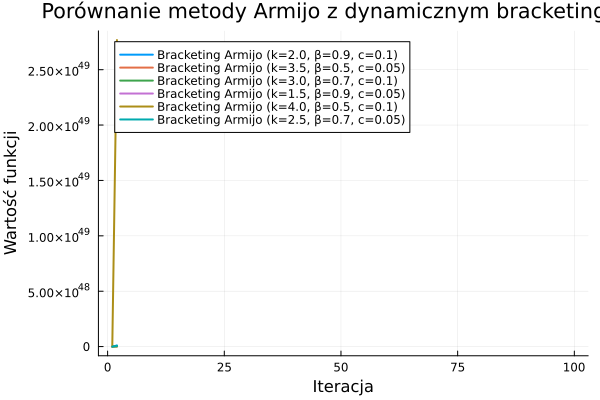

In [16]:
armijo_bracket_results = Dict()
iterations = 100

for (k, (β, c)) in zip(k_values, armijo_params)
    avg_costs = zeros(iterations)
    for (x0, y0) in start_points
        x_opt, y_opt, cost_history = gradient_descent_armijo_bracket(x0, y0, iterations, himmelblau, himmelblau_gradient, k, β, c)
        avg_costs += cost_history
    end
    avg_costs /= num_points
    armijo_bracket_results[(k, β, c)] = avg_costs
end

plt = plot(title="Porównanie metody Armijo z dynamicznym bracketingiem", xlabel="Iteracja", ylabel="Wartość funkcji")

for ((k, β, c), costs) in armijo_bracket_results
    if !isempty(costs)
        plot!(plt, 1:iterations, costs, label="Bracketing Armijo (k=$k, β=$β, c=$c)", lw=2)
    else
        println("Brak danych dla Bracketing Armijo (k=$k, β=$β, c=$c)")
    end
end

display(plt)